# 02 Labeling Functions

Now we'll actually use `snorkel` for something. The project has three basic parts:

* labeling functions: write pseudo-labels for your data
* transformation functions: for dynamic data augmentation
* slicing functions: for segmenting problematic cases so that you can explicitly add model capacity to handle them

The only one we'll cover in this example is labeling functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
from snorkel.labeling.preprocess import preprocessor
from snorkel.labeling.apply import PandasLFApplier
from snorkel.labeling.lf import labeling_function
from snorkel.types import DataPoint

POS = 1
NEG = 0 #-1
ABSTAIN = -1 #0

## Load our data from the previous notebook

In [3]:
prep_df = pd.read_csv("groupname_preprocessed_full.csv")
len(prep_df)

844782

In [4]:
prep_df.head()

,end,eventid,label,labeled_sentence,name,sentence,start,type
0,35,197001010002,0,1/1/1970: Unknown ENTSTART African American E...,african american,1/1/1970: Unknown African American assailants...,19,NORP
1,100,197001010002,0,1/1/1970: Unknown African American assailants...,cairo,1/1/1970: Unknown African American assailants...,95,GPE
2,110,197001010002,0,1/1/1970: Unknown African American assailants...,illinois,1/1/1970: Unknown African American assailants...,102,GPE
3,125,197001010002,0,1/1/1970: Unknown African American assailants...,united states,1/1/1970: Unknown African American assailants...,112,GPE
4,39,197001010002,0,"There were no casualties, however, ENTSTART o...",one,"There were no casualties, however, one bullet...",36,CARDINAL


In [5]:
prep_df.type.value_counts()

GPE         307406
ORG         234340
CARDINAL    155530
PERSON       76829
NORP         40913
LOC          17306
FAC           9694
PRODUCT       1755
EVENT          524
LAW            394
LANGUAGE        91
Name: type, dtype: int64

## Make some labeling functions

In [6]:
pos_types = {"ORG", "PERSON"}
@labeling_function(resources=dict(pos_types=pos_types))
def LF_pos_type(x, pos_types):
    if x.type in pos_types:
        return POS
    else:
        return ABSTAIN

In [7]:
neg_types = {"GPE", "CARDINAL", "NORP", "TIME", "LOC", "FAC",
            "EVENT", "LAW", "LANGUAGE"}
@labeling_function(resources=dict(neg_types=neg_types))
def LF_neg_type(x, neg_types):
    if x.type in neg_types:
        return NEG
    else:
        return ABSTAIN

In [8]:
@labeling_function()
def LF_claimed_credit(x):
    # Does "claimed credit" appear after the name?
    sent_after = x.sentence[x.end:]
    if "claimed credit" in sent_after:
        return POS
    else:
        return ABSTAIN

In [9]:
@labeling_function()
def LF_was_suspected(x):
    # Does "was suspected" appear after the name?
    sent_after = x.sentence[x.end:]
    if "was suspected" in sent_after:
        return POS
    else:
        return ABSTAIN

In [10]:
next_words = {"attacked", "ambushed", "killed", "abducted",
             "kidnapped", "detonated", "bombed"}
@labeling_function(resources=dict(next_words=next_words))
def LF_next_words(x, next_words):
    # do the next words after the entity fall in this list?
    sent_after = x.sentence[x.end:]
    next_tokens = sent_after.split()[:3]
    for tok in next_tokens:
        if tok in next_words:
            return POS
    return ABSTAIN

"round 2"

In [11]:
prev_words = {"killed", "targeting", "shot", 
              "targeted", "kidnapped"}
@labeling_function(resources=dict(prev_words=prev_words))
def LF_prev_words(x, prev_words):
    # these words tended to show up right before entities
    # in false-positive casses
    sent_before = x.sentence[:x.start]
    if len(sent_before.split()) > 0:
        prev_token = sent_before.split()[-1]
        if prev_token in prev_words:
            return NEG
        else:
            return ABSTAIN
    return ABSTAIN

In [12]:
not_a_terrorist_clues = {"avenue", "police", "radio",
                         "department", "hotel"}
@labeling_function(resources=dict(tokens=not_a_terrorist_clues))
def LF_prob_not_terrorist(x, tokens):
    # some words that showed up inside names of
    # entities misidentified as terrorists
    name_tokens = str(x["name"]).lower().split()
    for t in name_tokens:
        if t in not_a_terrorist_clues:
            return NEG
    return ABSTAIN

In [13]:
prepositions = {"of", "at", "in", "near"}
@labeling_function(resources=dict(prepositions=prepositions))
def LF_after_preposition(x, prepositions):
    # frequent mistakes included misattributing locations.
    # being part of a prepositional phrase might help indicate
    # a problem.
    sent_before = x.sentence[:x.start]
    prev_tokens = sent_before.split()[-2:]
    for t in prev_tokens:
        if t in prepositions:
            return NEG
    return ABSTAIN

In [14]:
known_groups = {"taliban", "islamic state", "isil", "isis",
               "boko haram", "al-qaida", "farc", "al-shabaab", "pkk"}
@labeling_function(resources=dict(known_groups=known_groups))
def LF_known_groups(x, known_groups):
    # some entities that are generally up to no good
    for k in known_groups:
        if k in str(x["name"]).lower():
            return POS
    return ABSTAIN

## Compute a label matrix for the dataset

In [15]:
applier = PandasLFApplier([
    #LF_pos_type,
    LF_neg_type,
    LF_claimed_credit,
    LF_was_suspected,
    #LF_next_words,
    LF_prev_words,
    LF_prob_not_terrorist,
    LF_after_preposition,
    LF_known_groups
])

In [16]:
L = applier.apply(prep_df)

100%|██████████| 844782/844782 [05:42<00:00, 2469.11it/s]


There are a couple ways we could build label estimates out of this matrix- since we have ground truth let's cheat and compare them.

In [17]:
labels = prep_df.label.values

In [30]:
labels.mean()

0.10469209807974128

In [18]:
print(type(L))
print(L.shape)

<class 'numpy.ndarray'>
(844782, 7)


"Coverage" is an important thing to keep track of- what fraction of the dataset has non-abstention answers from the labeling functions:

In [19]:
from snorkel.analysis import metrics

In [20]:
metrics._coverage_score(L)

0.9507790175453549

OK, that seems high. Are we using this right? Let's check the documentation:

In [21]:
print(metrics._coverage_score.__doc__)

None


Alright we'll compute it the old-fashioned way:

In [22]:
round(1-(L == -1).all(axis=1).sum()/L.shape[0], 4)

0.7275

In [23]:
L.shape

(844782, 7)

In [24]:
for i in range(L.shape[1]):
    fn_preds = L[:,i]
    nonempty = fn_preds > -1
    print(i, np.mean(fn_preds[nonempty] == labels[nonempty]))

0 0.9381018993791576
1 0.5454545454545454
2 0.6878531073446328
3 0.9971861181830363
4 0.9911221590909091
5 0.9467888174481482
6 0.9674574541744105


In [25]:
from snorkel.labeling.model.baselines import MajorityLabelVoter
from snorkel.labeling.model.label_model import LabelModel
from snorkel.analysis.error_analysis import error_buckets

In [26]:
votermodel = MajorityLabelVoter(2)

In [27]:
votermodel.fit(L)

In [28]:
votermodel.score(L, labels, metrics=["accuracy", "f1",
                                    "roc_auc"])

{'accuracy': 0.8190314187565549,
 'f1': 0.3389330669676254,
 'roc_auc': 0.6998127249241689}

In [31]:
labmodel = LabelModel(2)
labmodel.fit(L)

Computing O...
Estimating \mu...
[0 epochs]: TRAIN:[loss=0.154]
[10 epochs]: TRAIN:[loss=0.045]
[20 epochs]: TRAIN:[loss=0.005]
[30 epochs]: TRAIN:[loss=0.006]
[40 epochs]: TRAIN:[loss=0.002]
[50 epochs]: TRAIN:[loss=0.001]
[60 epochs]: TRAIN:[loss=0.000]
[70 epochs]: TRAIN:[loss=0.000]
[80 epochs]: TRAIN:[loss=0.000]
[90 epochs]: TRAIN:[loss=0.000]
Finished Training


In [32]:
labmodel.score(L, labels, metrics=["accuracy", "f1",
                                  "roc_auc"])

{'accuracy': 0.8172735688023656,
 'f1': 0.33820931867679593,
 'roc_auc': 0.7130785023905771}

In [33]:
prob_labels = labmodel.predict_proba(L)

In [34]:
pos_probs = prob_labels[:,1]

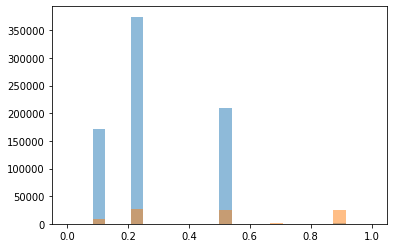

In [35]:
plt.hist(pos_probs[labels==0], bins=np.linspace(0,1,25), alpha=0.5)
plt.hist(pos_probs[labels==1], bins=np.linspace(0,1,25), alpha=0.5);

In [40]:
non_covered = L.max(axis=1) < 0
non_covered.sum()

230228

In [41]:
pos_probs[non_covered]

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [42]:
pos_probs.shape

(844782,)

In [43]:
pos_probs.tofile("pos_probs.numpy")